In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import gc
import json
from tqdm.auto import tqdm
tqdm.pandas()

warnings.simplefilter("ignore")
%matplotlib inline

/media/anirudh/Data/Code/anaconda3/envs/pers/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# To get review json
line_count = len(open("../data/review.json").readlines())
user_ids, business_ids, stars, dates = [], [], [], []
with open("../data/review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]

ratings = pd.DataFrame(
 {"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates}
)
user_counts = ratings["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()

In [3]:
# To get business json

line_count = len(open("../data/business.json").readlines())
name, business_id, address, city, state, postal_code = [], [], [], [], [], []
latitude, longitude, stars, review_count = [], [], [], []
is_open, attributes, GoodForKids, categories, hours = [], [], [], [], []

with open("../data/business.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        name += [blob["name"]]
        business_id += [blob["business_id"]]
        address += [blob["address"]]
        city += [blob["city"]]
        state += [blob["state"]]
        postal_code += [blob["postal_code"]]
        latitude += [blob["latitude"]]
        longitude += [blob["longitude"]]
        stars += [blob["stars"]]
        review_count += [blob["review_count"]]
        is_open += [blob["is_open"]]
        
business = pd.DataFrame(
 {"name":name, "business_id":business_id, "address":address, "city":city, "state":state, "postal_code":postal_code, 
    "latitude":latitude, "longitude":longitude, 'stars': stars, 'review_count': review_count, 'is_open':is_open}
)


In [4]:
business.head(2)

,name,business_id,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open
0,Arizona Biltmore Golf Club,1SWheh84yJXfytovILXOAQ,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0
1,Emerald Chinese Restaurant,QXAEGFB4oINsVuTFxEYKFQ,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1


In [5]:
ratings.head(2)

,user_id,business_id,rating,date
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33


In [6]:
detail_df = pd.merge(left=ratings,right=business,on='business_id', how='left')
mean_lat = detail_df.groupby('user_id')['latitude'].mean().reset_index()
mean_long = detail_df.groupby('user_id')['longitude'].mean().reset_index()
mean_df = pd.merge(mean_lat,mean_long, on='user_id')
mean_df.columns = ['user_id','mean_lat','mean_long']
detail_df = pd.merge(detail_df, mean_df, on='user_id', how='left')

detail_df['distance'] = ((detail_df['mean_lat'] - detail_df['latitude'])**2) + ((detail_df['mean_long'] - detail_df['longitude'])**2)

In [7]:
# For date distances
detail_df['date'] = pd.to_datetime(detail_df['date'])
last_date = detail_df.groupby('user_id')['date'].max().reset_index()
last_date.columns = ['user_id','last_date']
detail_df = pd.merge(detail_df,last_date,on='user_id',how='left')

# Months instead of days
detail_df['date_diff'] = (detail_df['last_date'] - detail_df['date'])
detail_df['date_diff'] = detail_df['date_diff'].dt.days/30

In [8]:
# Applying opereations on the dist
# e(1/1+dist)/e
# e(1/ log(date))/e
detail_df['dist_scale'] = np.exp(1/ (1 + detail_df['distance']))/(np.exp(1))
detail_df['date_scale'] = np.exp(1/ (1 + np.log(detail_df['date_diff']+1)))/np.exp(1)

# Multiplying rating scale with the dist 
detail_df['date_rating'] = detail_df['rating'] * detail_df['date_scale']
detail_df['dist_rating'] = detail_df['rating'] * detail_df['dist_scale']
detail_df['date_dist_rating'] = detail_df['date_scale'] * detail_df['dist_scale'] * detail_df['rating']

In [9]:
detail_df.head(2)

,user_id,business_id,rating,date,name,address,city,state,postal_code,latitude,...,mean_lat,mean_long,distance,last_date,date_diff,dist_scale,date_scale,date_rating,dist_rating,date_dist_rating
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36,MountainView Hospital,3100 N Tenaya Way,Las Vegas,NV,89128,36.215546,...,36.184735,-115.207442,0.002660,2016-08-11 03:38:43,39.7,0.997351,0.454974,0.454974,0.997351,0.453768
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33,Kelly Cardenas Salon - Hard Rock Hotel & Casino,4455 Paradise Rd,Las Vegas,NV,89169,36.110083,...,38.742975,-98.527392,283.371937,2017-01-14 21:30:33,0.0,0.369175,1.000000,5.000000,1.845877,1.845877


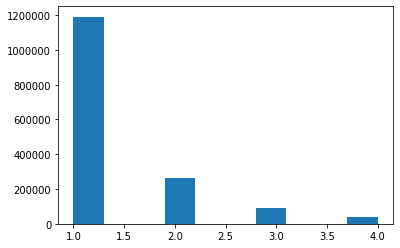

In [10]:
# Plotting number of cities rated by unique users
unique_user_city = detail_df.groupby('user_id')['city'].nunique().reset_index()
plt.hist(unique_user_city['city'][unique_user_city['city']<5])
plt.show()

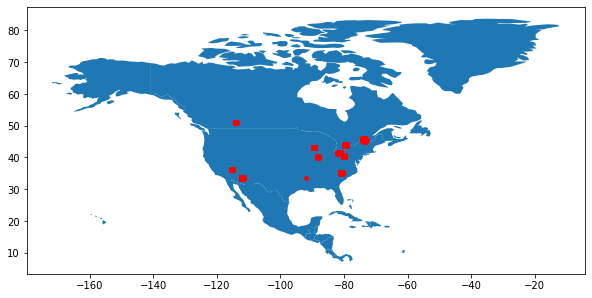

In [11]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(business['longitude'], business['latitude'])]
gdf = GeoDataFrame(business, geometry=geometry)   

# Plotting the location of businesses
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent=='North America']
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [12]:
detail_df.head(2)

,user_id,business_id,rating,date,name,address,city,state,postal_code,latitude,...,mean_lat,mean_long,distance,last_date,date_diff,dist_scale,date_scale,date_rating,dist_rating,date_dist_rating
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,2013-05-07 04:34:36,MountainView Hospital,3100 N Tenaya Way,Las Vegas,NV,89128,36.215546,...,36.184735,-115.207442,0.002660,2016-08-11 03:38:43,39.7,0.997351,0.454974,0.454974,0.997351,0.453768
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,2017-01-14 21:30:33,Kelly Cardenas Salon - Hard Rock Hotel & Casino,4455 Paradise Rd,Las Vegas,NV,89169,36.110083,...,38.742975,-98.527392,283.371937,2017-01-14 21:30:33,0.0,0.369175,1.000000,5.000000,1.845877,1.845877


In [13]:
cols = ['user_id','business_id', 'rating', 'date_rating', 'dist_rating', 'date_dist_rating']
detail_df[cols].head()

,user_id,business_id,rating,date_rating,dist_rating,date_dist_rating
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,0.454974,0.997351,0.453768
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,5.000000,1.845877,1.845877
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,2.340022,4.986967,2.333923
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,5.000000,4.989108,4.989108
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,0.501546,0.993283,0.498177


In [14]:
detail_df[cols].to_csv('../data/time_location_aware.csv',index=False)